# <a id="top"></a>Autoencoding Edward Hopper:<br>Using deep learning to recommend art

[Larry Finer](mailto:lfiner@gmail.com)  
March 2019

The goal of this project was to build a model that would take an image of an artwork and compare it visually to a corpus of more than 100,000 artworks from museums and other sources in order to find works that are similar visually. The main steps in the project were:

1. Download artwork images and metadata from multiple sites
2. Combine metadata into a single pandas dataframe
3. Develop a convolutional neural network autoencoder model that adequately reproduces the images  
4. **Extract the narrowest encoded layer and use it to encode the entire corpus as well as a test image; then compare the test image to the entire corpus using a cosine distance measure to find the nearest images** (this file)  
 
<hr>

## 4. Encode corpus and compare test image

### Sections
[4a. Imports and setup](#4a)  
[4b. Convert corpus of original images into tensors](#4b)  
[4c. Convert original tensors to (much smaller) feature tensors](#4c)  
[4d. Convenience tool to display original and predicted (autoencoded) images](#4d)  
[4e. Compare test image to corpus and find closest matches](#4e)
<hr>

### <a id="4a"></a>4a. Imports and setup

In [6]:
import numpy as np
import pandas as pd
import os
import cv2
import pickle
import json

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Input
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
import matplotlib.pyplot as plt

from scipy import spatial

from IPython.display import display, Image

Using TensorFlow backend.


In [7]:
# Parameters
image_dimension = 200
batch_size = 10000

### <a id="4b"></a>4b. Convert corpus of original images into tensors

In [4]:
# Define a couple of functions that use OpenCV to convert images to 3D 
# (image_dim, image_dim, 3) or 4D (1, image_dim, image_dim, 3) tensors as needed

def image_to_3d_tensor(image_path):
    im = cv2.resize(cv2.imread(image_path), (image_dimension, image_dimension)).astype(np.float32)
    return im/255

def image_to_4d_tensor(image_path):
    im = image_to_3d_tensor(image_path)
    im = im.reshape(1, image_dimension, image_dimension, 3)
    return im

In [11]:
# Establish corpus image directory.
corpus_image_directory = '../data/images/allimages/'
corpus_image_count = len([name for name in os.listdir(corpus_image_directory)])
print(corpus_image_count)

107278


In [ ]:
# Instantiate the tensors array and the list that will contain filenames.
corpus_tensors = np.zeros((1, image_dimension, image_dimension, 3))
corpus_tensors_list = []
corpus_filenames = []

In [ ]:
# Create the image tensors and the filename list.
for filename in os.listdir(corpus_image_directory):
    corpus_filenames.append(filename)
    corpus_tensors_list.append(image_to_3d_tensor(corpus_image_directory + filename))
    if len(corpus_tensors_list) % 50 == 0: print('Processed:', len(corpus_tensors_list))
corpus_tensors = np.array(corpus_tensors_list)

In [6]:
# Save the tensors and filenames.
pickle.dump(corpus_tensors, open('../data/autoencoder/models/corpus_tensors.pickle', 'wb'), protocol=4)
pickle.dump(corpus_filenames, open('../data/autoencoder/models/corpus_filenames.pickle', 'wb'))

In [58]:
corpus_tensors.shape

(25899, 200, 200, 3)

### <a id="4c"></a>4c. Convert original tensors to (much smaller) feature tensors

In [1]:
# Convenience code to reload tensors and filenames if necessary.
# This takes a while.
corpus_tensors = pickle.load(open('../data/autoencoder/models/corpus_tensors.pickle', 'rb'))

In [2]:
# Load feature extractor.
feature_extractor = load_model('../data/autoencoder/models/feature_extractor.h5')

In [12]:
# Predict feature values using feature extractor.
# This takes a while.
corpus_features = feature_extractor.predict(corpus_tensors, verbose=1)

107278/107278 [==============================] - 2558s 24ms/step


In [13]:
# Save corpus features for later use
pickle.dump(corpus_features, open('../data/autoencoder/models/corpus_features.pickle', 'wb'), protocol=4)

### <a id="4d"></a>4d. Convenience tool to display original and predicted (autoencoded) images

In [42]:
# Load corpus filenames.
corpus_filenames = pickle.load(open('../data/autoencoder/models/corpus_filenames.pickle', 'rb'))

In [43]:
# Load corpus metadata that was created previously
corpus_metadata = pd.read_json('../data/autoencoder/models/corpus_metadata.json')

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# Load autoencoder model
autoencoder = load_model('../data/autoencoder/models/final_autoencoder.h5')

In [88]:
def display_orig_and_encoded(image):
    orig = image_to_3d_tensor(image)
    pred = autoencoder.predict(orig.reshape(1, image_dimension, image_dimension, 3))\
            .reshape(image_dimension, image_dimension, 3)
    # print(orig.shape, pred.shape)
    plt.figure(figsize=(12, 10))
    plt.subplot(221)
    plt.imshow(orig)
    plt.title('Original')
    plt.subplot(222)
    plt.imshow(pred)
    plt.title('Encoded')

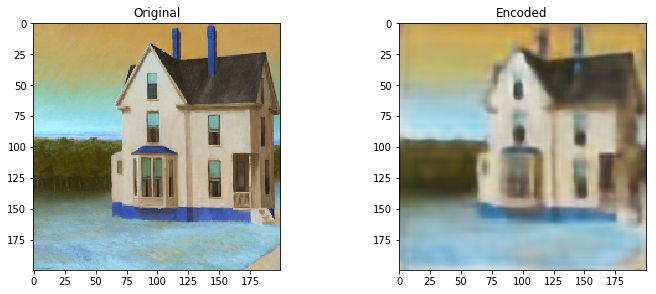

In [89]:
display_orig_and_encoded('../data/autoencoder/test/images/hopper.jpg')

Colors are off because OpenCV uses BGR instead of RBG encoding. (Baseboard of house should be red instead of blue.)

### <a id="4e"></a>4e. Compare test image to corpus and find closest matches

In [34]:
# Convenience code to reload corpus features.
corpus_features = pickle.load(open('../data/autoencoder/models/corpus_features.pickle', 'rb'))

In [130]:
corpus_features.shape

(107278, 25, 25, 16)

In [5]:
def compare_test_image(test_image_file, metric='cosine'):
    # Display original image
    print('Original image')
    display(Image(test_image_file, width = image_dimension, height = image_dimension))
    
    # Predict feature values for test image
    test_tensor = image_to_4d_tensor(test_image_file)
    test_features = feature_extractor.predict(test_tensor)
    
    # Use a vectorized function (spatial.distance.cdist) to calculate the distance between
    # the test image and each of the images in the corpus.
    # Images need to be converted to '2d' for use in distance.cdist.
    # First dimension is number of images (1 for test, corpus size for corpus).
    # Second dimension is width x height x number of color channels.
    test_features_2d = np.reshape(test_features, (test_features.shape[0], test_features.shape[1] * test_features.shape[2] * test_features.shape[3]))
    corpus_features_2d = np.reshape(corpus_features, (corpus_features.shape[0], corpus_features.shape[1] * corpus_features.shape[2] * corpus_features.shape[3]))
    # Run the comparison.
    distance_array = spatial.distance.cdist(test_features_2d, corpus_features_2d, metric=metric)

    # If #1 best match is virtually indistinguishable from test image, 
    # then it is most likely the same image, so skip it.
    shift = 0
    if np.min(distance_array) < .001: shift = 1
        
    # Pull the top 5 id numbers using argsort.
    top5ids = [corpus_filenames[index][:-4] for index in distance_array.argsort()[0][0+shift:5+shift].tolist()]
    top5list = []
    print('Closest matches')
    for index, value in enumerate(top5ids):
        artwork = {}
        artwork['order'] = index
        artwork['image_url'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'image_url'].item()
        artwork['artist'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'artist'].item()
        artwork['title'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'title'].item()
        artwork['date'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'date'].item()
        artwork['medium'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'medium'].item()
        artwork['page_url'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'page_url'].item()
        artwork['resubmit'] = 'placeholder'
        top5list.append(artwork)
        display(Image(url = artwork['image_url'], format = 'jpg', width = image_dimension, height = image_dimension))
    return(top5list)

Original image


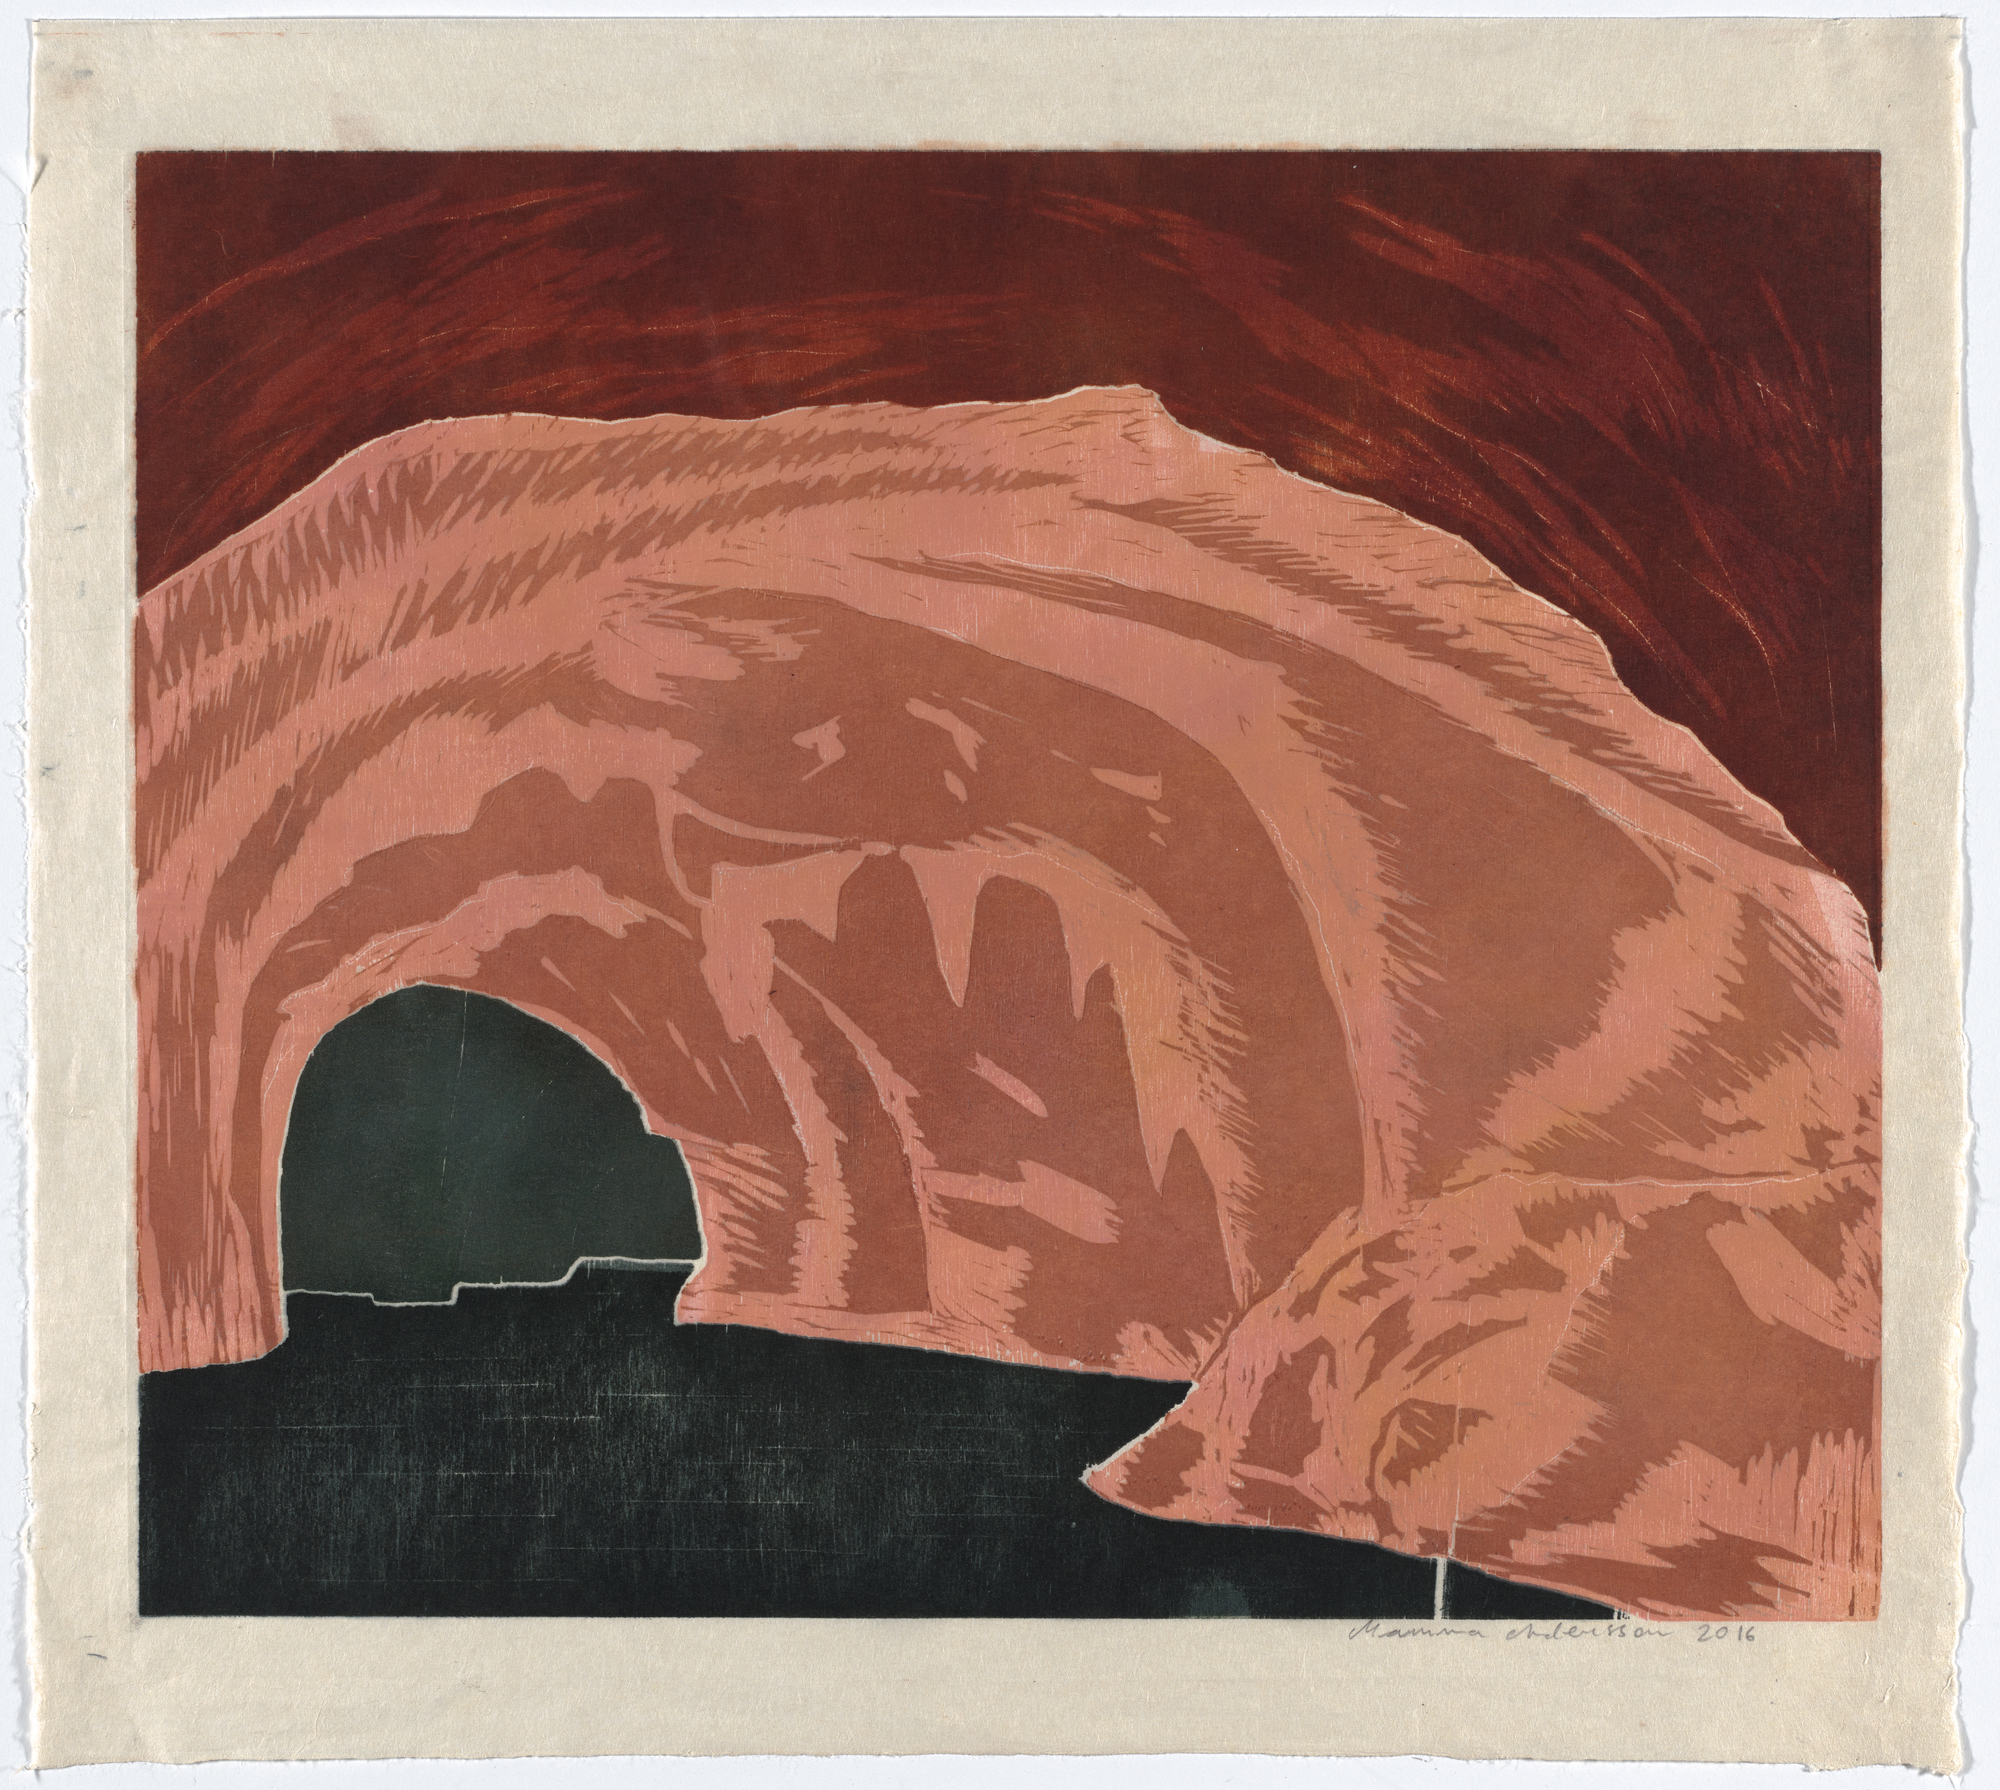

Closest matches


In [112]:
# Actually execute the comparison for a test image.
top5 = compare_test_image('../data/autoencoder/test/images/moma291965.jpg')

Colors of these images are correct.

In [86]:
top5

[{'order': 0,
  'image_url': 'http://www.moma.org/media/W1siZiIsIjIyOTU1NSJdLFsicCIsImNvbnZlcnQiLCItcmVzaXplIDMwMHgzMDBcdTAwM2UiXV0.jpg?sha=8283fbf8e0cfd4f8',
  'artist': 'Max Ernst',
  'title': 'The Parisian',
  'date': '1950',
  'medium': 'Plaster',
  'page_url': 'http://www.moma.org/collection/works/81448',
  'resubmit': 'placeholder'},
 {'order': 1,
  'image_url': 'http://www.moma.org/media/W1siZiIsIjI3MTg3NSJdLFsicCIsImNvbnZlcnQiLCItcmVzaXplIDMwMHgzMDBcdTAwM2UiXV0.jpg?sha=d0dd12a04b0d0a8c',
  'artist': 'Luigi Ghirri',
  'title': 'Week End',
  'date': '1973',
  'medium': 'Chromogenic color print',
  'page_url': 'http://www.moma.org/collection/works/165704',
  'resubmit': 'placeholder'},
 {'order': 2,
  'image_url': 'https://d5wt70d4gnm1t.cloudfront.net/media/a-s/artworks/nicole-gelinas/33590-854544473712/nicole-gelinas-melancholy-winter-billow-960x640.jpg',
  'artist': 'nicole-gelinas',
  'title': 'Melancholy Winter - Billow',
  'date': 2015,
  'medium': 'painting',
  'page_url': '